# TIME_SERIES — Financial Forecasting with SARIMAX

#### Author: Ricardo Ruiz
##### Project: Apple (AAPL) Stock Price Forecast
#### Estimation date: 07/06/2023 (June 7, 2023)
#### Forecast horizon: up to 2025-07-31
#### Stack: Python (pandas, statsmodels, pmdarima, arch, matplotlib), yfinance

Goal. Build an interpretable, statistically rigorous forecasting pipeline for AAPL using SARIMAX, with proper diagnostics, backtesting, and a 2-year horizon. We compare ARIMA/SARIMA/SARIMAX vs VAR/VARMAX and account for conditional heteroskedasticity via GARCH.

## Import relevant libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from arch import arch_model
from scipy.stats import chi2
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import scipy.stats
import pylab
import scipy.optimize as spop
import yfinance as yf
from pmdarima import auto_arima
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Exploratory data analysis and visualization



### Import data: Stock daily price for the last 5 years of several firms
#### The firms are represented with yahoo finance symbols, AAPL= Apple
#### Returns are calculated as percent change of stock price over time

In [2]:
symbols = ['AAPL','GOOGL', 'MSFT', 'AMZN', 'NVDA', 'BAC', 'XOM', 'WMT', 'JNJ', 'V', 'PG', 'T', 'INTC', 'VZ', 'UNH', 'MA', 'CVX', 'PFE', 'KO','NDAQ', 'GSP']
data = yf.download(symbols, period="5y")['Adj Close']
returns = data.pct_change().fillna(method = "bfill")

[*********************100%***********************]  21 of 21 completed


In [3]:
data.head(20)

,AAPL,AMZN,BAC,CVX,GOOGL,GSP,INTC,JNJ,KO,MA,...,NDAQ,NVDA,PFE,PG,T,UNH,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-23,45.779240,90.099998,27.386086,97.444710,60.549999,16.330000,45.373489,110.846924,38.433815,202.211777,...,29.411873,61.783066,29.402601,69.003281,15.666281,234.714355,135.431198,39.815262,80.320763,62.835907
2018-07-24,46.111332,91.461998,27.457336,99.468620,62.907501,16.469999,45.260723,113.236664,38.698875,203.904663,...,29.325645,61.609665,29.789783,69.425140,16.009928,235.661591,135.431198,40.411503,80.623215,64.078751
2018-07-25,46.546162,93.180496,27.671082,100.311920,63.797001,16.740000,45.477585,112.588882,39.408550,208.360626,...,28.980749,62.392452,30.018944,69.847038,15.287258,236.683136,137.955521,39.940777,80.568214,64.526459
2018-07-26,46.400425,90.400002,27.555304,99.548935,64.275002,16.709999,45.243382,114.041954,39.536808,201.754532,...,28.965345,63.128174,30.153276,70.391953,15.337797,238.670547,137.820084,40.152607,80.870720,65.028229
2018-07-27,45.628719,90.863503,27.662176,101.171272,62.644501,16.639999,41.357441,115.153694,39.511158,197.444504,...,29.464220,62.429611,30.350821,70.822617,15.706711,237.695450,136.088882,40.803776,80.779022,63.237312
2018-07-30,45.373070,88.960999,27.884827,102.665115,61.501999,16.840000,41.366127,115.696396,39.528255,192.511795,...,28.488033,60.475121,30.493057,70.488640,16.171646,235.735886,131.997833,41.180351,81.466476,63.098389
2018-07-31,45.463871,88.872002,27.501863,101.412216,61.361000,16.681999,41.721752,116.002792,39.870274,192.638290,...,28.146210,60.655960,31.551897,71.086288,16.156487,235.160126,132.249268,40.513493,81.787292,62.920837
2018-08-01,48.142143,89.858498,27.831394,100.705460,61.649502,16.379999,42.337608,116.107826,39.665062,195.751633,...,28.143127,61.054783,31.820560,70.884140,16.121111,235.299438,133.709686,40.584103,80.879868,62.056259
2018-08-02,49.549381,91.716499,27.858110,99.396347,62.056499,16.549999,42.918766,114.891113,39.485504,196.539658,...,28.253992,62.082802,31.597418,72.070663,16.095842,237.816132,134.357666,40.780235,81.356491,61.685719


### Descriptive statistics

In [4]:
data["AAPL"].describe()

count    1258.000000
mean      109.895549
std        46.880274
min        34.209969
25%        57.523931
50%       123.432472
75%       148.628410
max       195.100006
Name: AAPL, dtype: float64

The average stock price over the sample period was $109.83, but the relatively high standard deviation of $46.84 highlights considerable volatility in Apple’s valuation. The observed range, from a minimum of $34.21 to a maximum of $195.10, underscores the extent of potential fluctuations investors might face.

Examining the quartiles provides further insight: the 25th percentile at $57.51, the median (50th percentile) at $123.40, and the 75th percentile at $148.50 reveal a skewed distribution. The gap between the median and the upper quartile suggests periods of elevated valuations, potentially driven by outlier events. Such outliers should be carefully considered, as they can significantly influence portfolio risk and investment decisions.

In [5]:
returns["AAPL"].describe()

count    1258.000000
mean        0.001370
std         0.020981
min        -0.128647
25%        -0.008828
50%         0.001369
75%         0.012770
max         0.119808
Name: AAPL, dtype: float64

he mean return of 0.12% reflects a modest but positive average performance over the observed period. However, the standard deviation of 1.80% underscores the high variability in daily returns, consistent with the inherent volatility of equity markets.

The extreme values—ranging from a minimum of −12.87% to a maximum of +11.98%—highlight the potential for significant short-term swings, reinforcing the risk associated with holding Apple’s stock.

Examining the quartiles offers additional insight into the return distribution: the 25th percentile at −0.71%, the median (50th percentile) at 0.10%, and the 75th percentile at 1.04%. This spread illustrates the asymmetry of outcomes and the presence of tail risks that investors must manage.

From an investment perspective, the variability of returns emphasizes the importance of diversification and robust risk management strategies. Despite this volatility, Apple has delivered outstanding long-term results: a 5-year total price return of 326%, supported by strong fundamentals (market capitalization of $3.05 trillion in 2023, solid revenue and net income growth). Analysts remain broadly optimistic, with 35 buy ratings and a 12-month price target of $185.94. Nevertheless, the stock has experienced meaningful fluctuations, trading within a 52-week range of $124.17 to $194.48.


## Data visualization

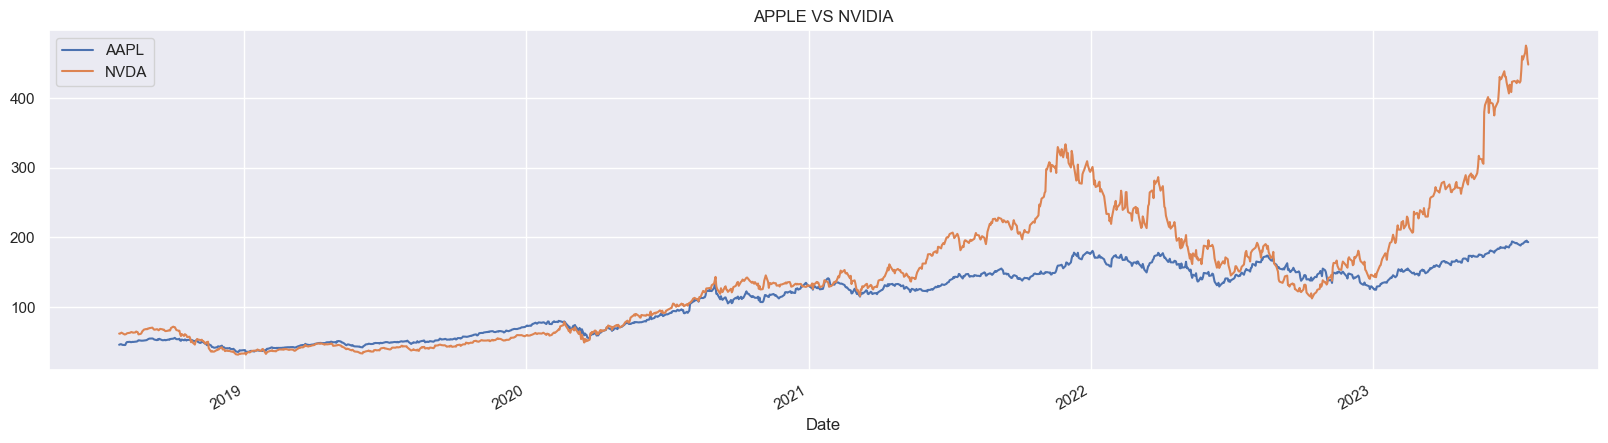

In [6]:
data["AAPL"].plot(figsize=(20,5), title = "Apple stock price")
data["NVDA"].plot(figsize=(20,5), title = "Nvidia stock price")
plt.legend(loc='upper left')
plt.title("APPLE VS NVIDIA")
plt.show()

Both time series exhibit clear upward trends. However, Nvidia’s stock appears significantly more volatile than Apple’s, with sharper fluctuations around its growth path.

Notably, the slope of Nvidia’s growth trajectory has steepened in recent years, reflecting the surge in global demand for advanced semiconductors driven by technological innovation (e.g., AI, cloud computing, and high-performance graphics). In addition, geopolitical factors such as the U.S.–China trade tensions have further amplified market volatility, making Nvidia’s price dynamics more sensitive compared to Apple’s relatively stable trend.

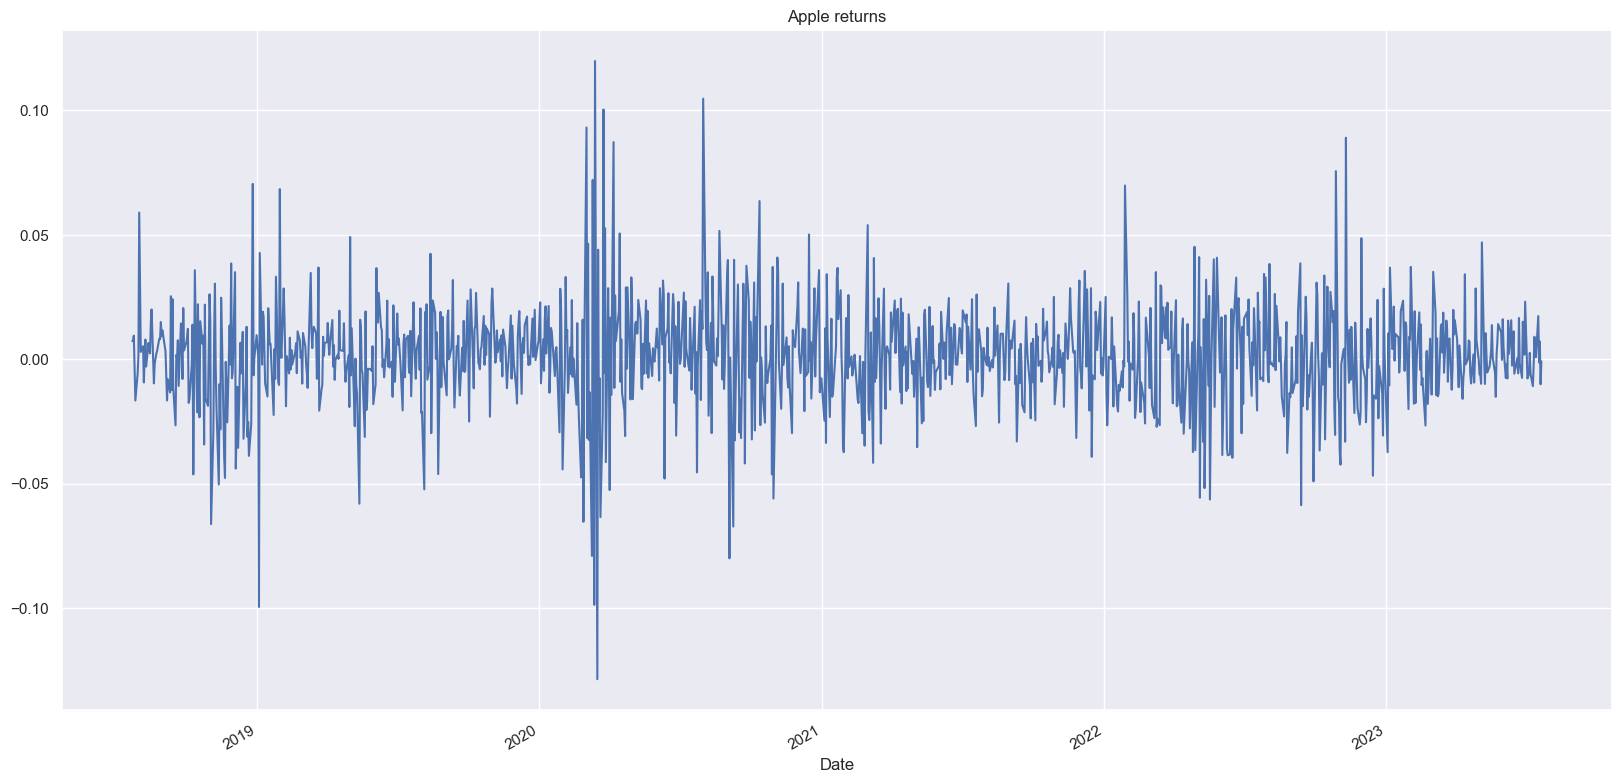

In [7]:
returns["AAPL"].plot(figsize=(20,10),title = "Apple returns")
plt.show()

Across time, Apple stock price seems to exhibit a positve trend, the returns exibit high volatility in 2020, graphic intuition says that the series are not stacionary: on the other hand, graphic intuition says that the returns are stacionary

#### Returns probability distributions

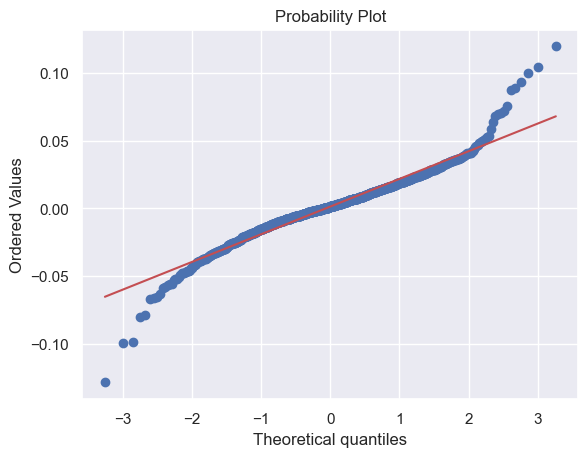

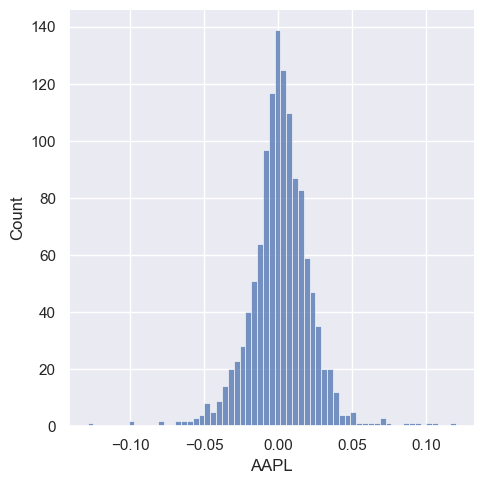

In [8]:
# Plot probability plot
scipy.stats.probplot(returns["AAPL"], plot = pylab)
# Plot distribution plot
sns.distplot(returns["AAPL"])
plt.show()

#### Stock price prob dist:

<function matplotlib.pyplot.show(close=None, block=None)>

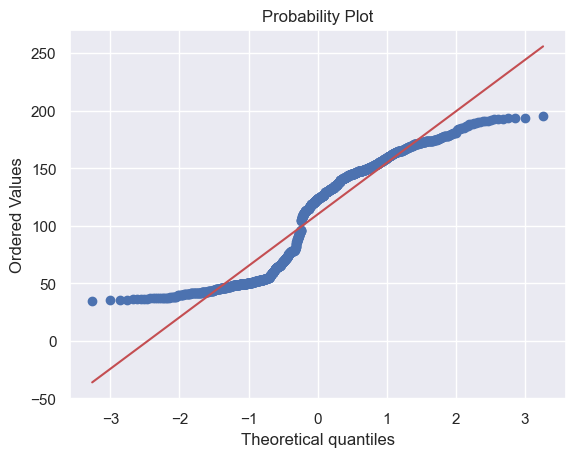

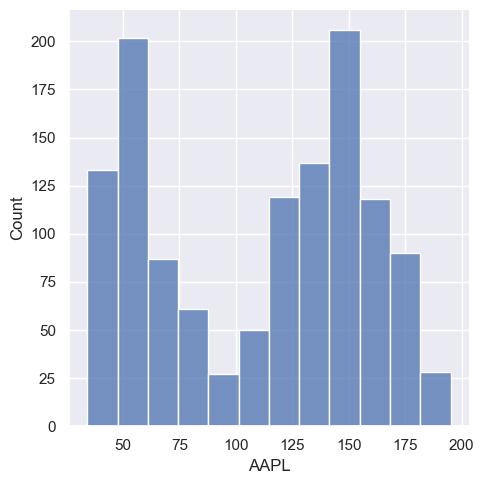

In [9]:
scipy.stats.probplot(data["AAPL"], plot = pylab)
sns.displot(data["AAPL"])
plt.show

The QQ plot and the distribution plots indicate that Apple’s stock price series deviates from normality, displaying skewness and heavy tails typical of financial time series. In contrast, the returns appear approximately normally distributed, which aligns with standard financial theory: while price levels often follow a non-stationary and non-normal process, log returns tend to be stationary and closer to Gaussian behavior.

This distinction is crucial, as most econometric models (e.g., ARIMA, GARCH) rely on the assumption of stationarity and, in some cases, approximate normality of residuals to produce valid forecasts and risk estimates.

### Data management and preparation

Be shure to set the date variable as "datetime" type and set as an index

In [10]:
data.index

DatetimeIndex(['2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03',
               ...
               '2023-07-10', '2023-07-11', '2023-07-12', '2023-07-13',
               '2023-07-14', '2023-07-17', '2023-07-18', '2023-07-19',
               '2023-07-20', '2023-07-21'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

We can observe the time variable has already been indexed in the data frame, also the date-time setting is present. Now only remaning task to do is setting the frecuency of our time series.

Convert data to monthly price and set frequency:

In [11]:
# to set data time settigns 
# pd.to_datetime(df_data.index, dayfirst=True)
# to set the index:
# df_data.set_index("Date", inplace= True)

In [12]:
data = data.resample('M').last()
returns = returns.resample('M').last()
data = data.resample('M').last()
returns = returns.resample('M').last()
data.index

DatetimeIndex(['2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31', '2021-01-31', '2021-02-28',
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31', '2023-01-31', '2023-02-28',
      

In this case the frequency is set for months 'M', for hour, day, month,weak and year, use H,D,M,W,Y respectively
Dont forget to fill mising values with fillna(method = "bfill") function


The sample size is :


In [13]:
print(returns.shape)
print (data.shape)

(61, 21)
(61, 21)


Check if there is missing values:

In [14]:
print(data.isnull().sum())
print(returns.isnull().sum())

AAPL     0
AMZN     0
BAC      0
CVX      0
GOOGL    0
GSP      0
INTC     0
JNJ      0
KO       0
MA       0
MSFT     0
NDAQ     0
NVDA     0
PFE      0
PG       0
T        0
UNH      0
V        0
VZ       0
WMT      0
XOM      0
dtype: int64
AAPL     0
AMZN     0
BAC      0
CVX      0
GOOGL    0
GSP      0
INTC     0
JNJ      0
KO       0
MA       0
MSFT     0
NDAQ     0
NVDA     0
PFE      0
PG       0
T        0
UNH      0
V        0
VZ       0
WMT      0
XOM      0
dtype: int64


Our data frame does not present mising values.


#### White noise

In [15]:
wn = np.random.normal(loc = data["AAPL"].mean(), scale = data["AAPL"].std(), size = len (data))

In [16]:
data.loc[:, 'wn'] = wn
data.describe()

,AAPL,AMZN,BAC,CVX,GOOGL,GSP,INTC,JNJ,KO,MA,...,NVDA,PFE,PG,T,UNH,V,VZ,WMT,XOM,wn
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,110.822263,122.859344,30.753842,111.641819,91.272295,16.015887,43.624456,144.606082,50.609157,308.201226,...,145.836635,37.726895,121.461815,17.652151,360.281220,192.615910,45.353470,123.625625,65.623343,102.289640
std,48.339805,32.439408,6.583880,33.501162,29.606179,4.662224,8.775035,19.760341,7.831725,58.511438,...,100.055753,7.089951,23.411824,1.691764,112.972054,31.134619,4.896464,21.081958,24.419205,42.339234
min,37.951187,75.098503,19.664438,61.663902,52.248001,6.680000,24.828327,114.442276,38.108898,183.753998,...,33.121407,27.462715,71.086288,14.393353,205.792938,128.028198,33.575001,81.787292,28.394690,-2.402132
25%,60.567390,94.187500,26.230955,91.286263,61.590000,13.510000,40.551216,125.184219,43.803978,270.100464,...,58.887451,32.452614,107.011017,16.457588,249.313156,174.378601,42.784279,107.927849,51.282547,71.025439
50%,123.166672,120.209503,28.690001,99.288757,88.230003,15.328500,45.105556,149.337891,49.630451,322.350159,...,133.387634,35.119759,127.537865,17.580276,323.821106,196.192703,46.872154,131.015472,58.022041,98.316528
75%,148.286743,157.436493,35.317802,139.947479,116.320000,19.655001,50.161972,161.037979,58.610630,354.752167,...,195.316605,42.533184,138.453308,18.411516,480.640015,216.154388,49.080826,140.676834,81.565331,133.472946
max,193.970001,175.353500,45.804184,179.941620,148.046005,26.150000,59.395275,175.405472,63.665134,399.519989,...,447.720001,56.065643,156.648163,21.839409,549.225159,242.828186,52.131908,158.425003,117.321945,198.494672


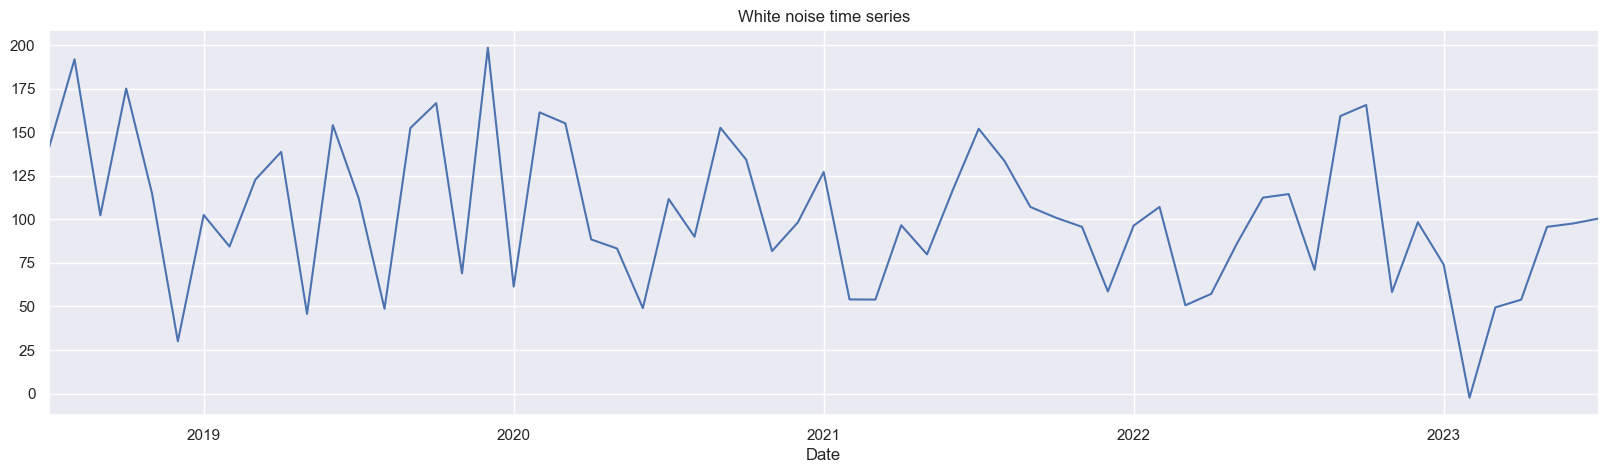

In [17]:
data["wn"].plot(figsize = (20,5))
plt.title("White noise time series")
plt.show()

We can observe the stationarity and normal distribution

### Dick.Fuller test for stationarity

H0: Non-stationarity H1: stationarity

In [18]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [19]:
# ADF Test on each column
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AAPL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4627
 No. Lags Chosen       = 0
 Critical value 1%     = -3.544
 Critical value 5%     = -2.911
 Critical value 10%    = -2.593
 => P-Value = 0.8991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "AMZN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6063
 No. Lags Chosen       = 0
 Critical value 1%     = -3.544
 Critical value 5%     = -2.911
 Critical value 10%    = -2.593
 => P-Value = 0.4804. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "BAC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit roo

In [20]:
for name, column in returns.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AAPL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1377
 No. Lags Chosen       = 0
 Critical value 1%     = -3.544
 Critical value 5%     = -2.911
 Critical value 10%    = -2.593
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AMZN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2468
 No. Lags Chosen       = 2
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BAC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

We fail to reject he null hypothesis, Apple stock price is non-stationary. On the other hand, we reject the null hypothesis for Apple returns data, returns series are stationary.

#### Seaonality decomposition

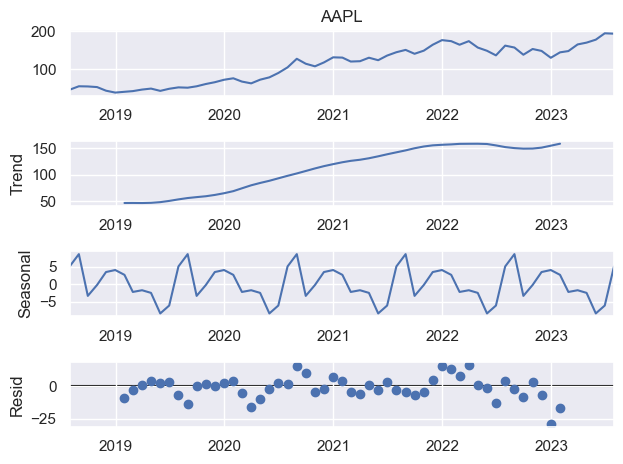

In [21]:
s_deck_additive = seasonal_decompose(data["AAPL"], model = "additive")
s_deck_additive.plot()
plt.show()

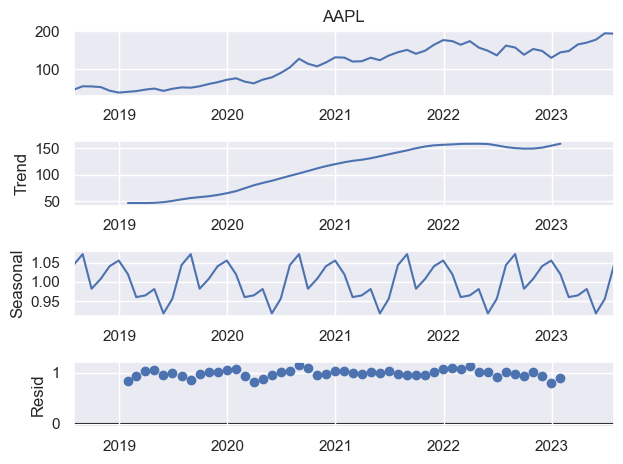

In [22]:
s_deck_mult = seasonal_decompose(data["AAPL"], model = "multiplicative")
s_deck_mult.plot()
plt.show()

A positive long-term trend is clearly observed in Apple’s stock price, accompanied by seasonal components that reflect recurring patterns in the data. The residuals display a noticeable increase in volatility after 2020, which may be attributed to structural shocks in the market—most notably the economic uncertainty and disruptions caused by the COVID-19 pandemic.

This behavior highlights two key features of financial time series:

Non-constant variance (heteroskedasticity): volatility clustering is typical in financial markets.

Structural breaks: exogenous shocks, such as the pandemic, can significantly alter the underlying dynamics of the series.

#### Autocorrelation and Partial autocorrelation

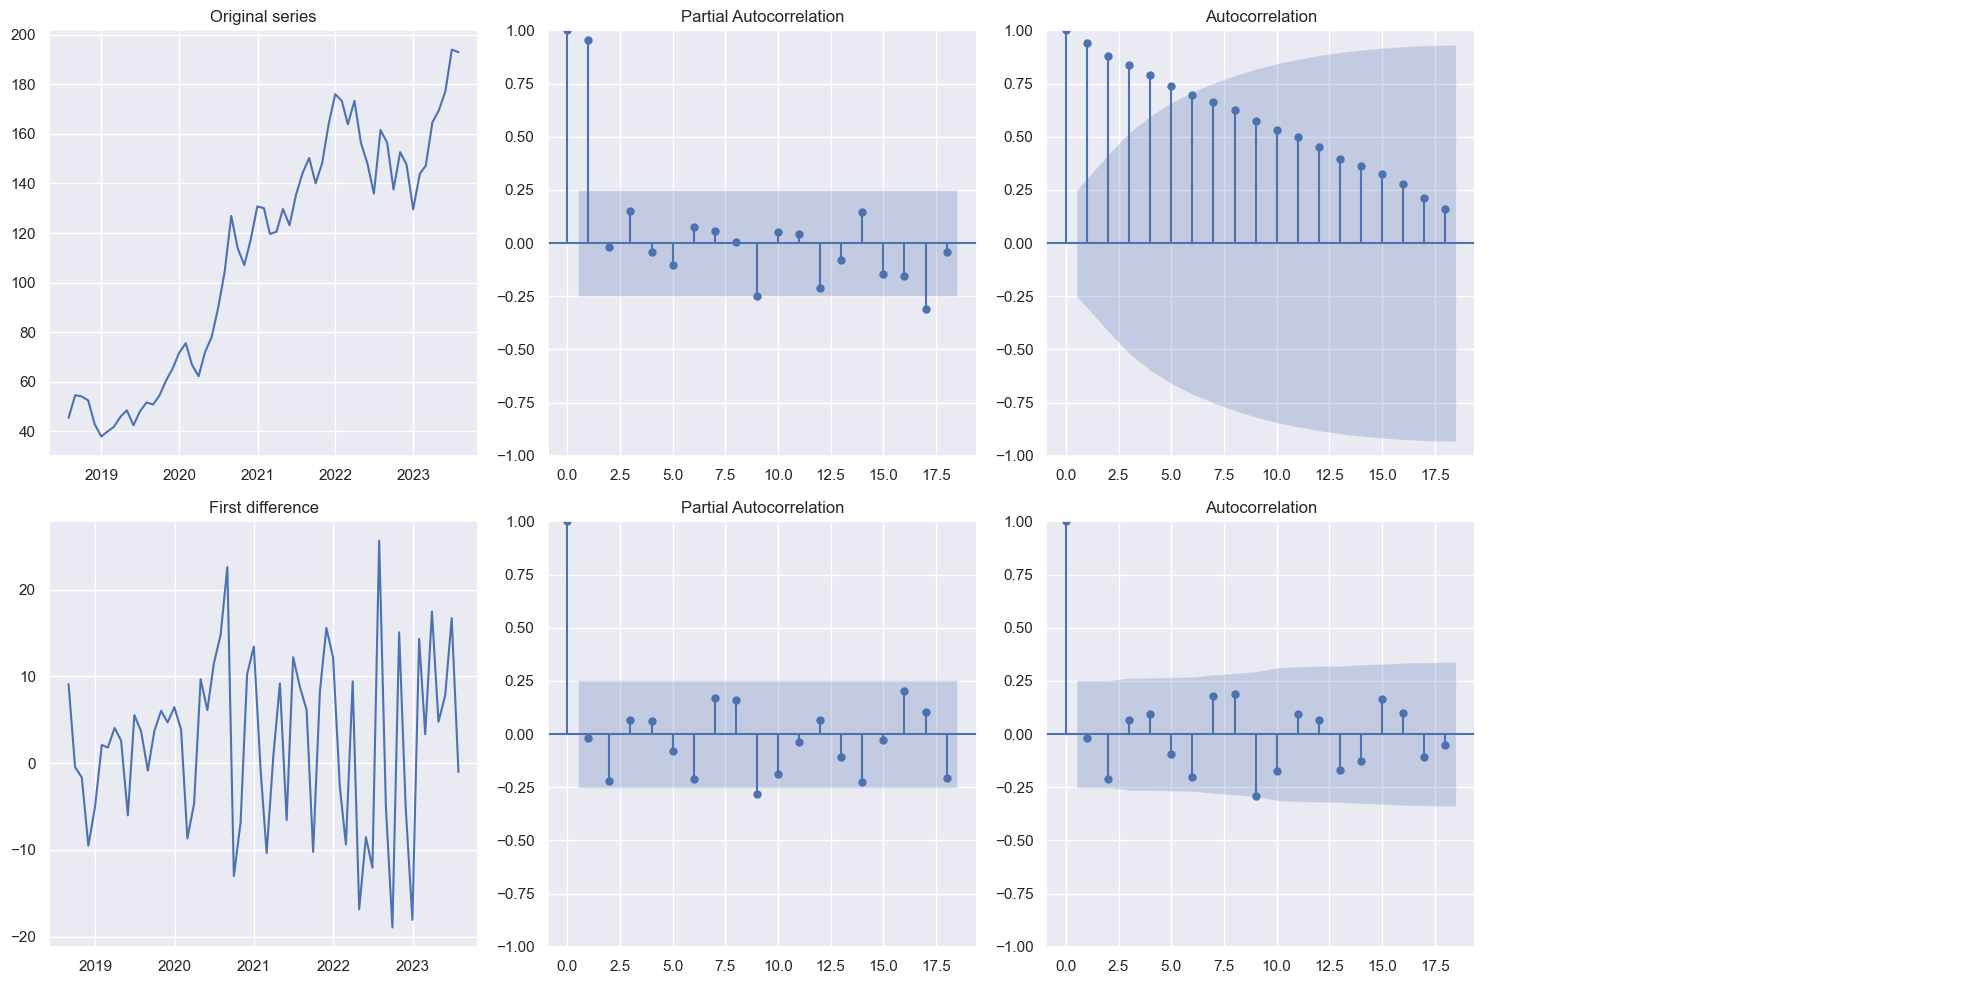

In [23]:
# Create a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Plot graph 1: Original series
axs[0, 0].plot(data['AAPL'])
axs[0, 0].set_title("Original series")

# Plot graph 1.2: PACF of the original series
plot_pacf(data['AAPL'], ax=axs[0, 1])

# Plot graph 2: ACF of the original series
plot_acf(data['AAPL'], ax=axs[0, 2])

# Plot graph 3: First difference
axs[1, 0].plot(data['AAPL'].diff().dropna())
axs[1, 0].set_title("First difference")

# Plot graph 3.2: PACF of the first difference
plot_pacf(data['AAPL'].diff().dropna(), ax=axs[1, 1])

# Plot graph 4: ACF of the first difference
plot_acf(data['AAPL'].diff().dropna(), ax=axs[1, 2])

# Remove empty plots in the last column
axs[0, 3].axis('off')
axs[1, 3].axis('off')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()




Based on the **autocorrelation (ACF)** and **partial autocorrelation (PACF)** plots, graphical intuition suggests that the **autoregressive (AR) order** should not exceed **2 lags**, while the **moving average (MA) order** is likely limited to **1 lag**.

However, the series itself is **non-stationary**, as confirmed by the Augmented Dickey–Fuller (ADF) test. To achieve stationarity, the series must be **differenced** at least once.

In ARIMA notation, this implies a potential model structure of:

$ARIMA(p,d,q) = ARIMA( \leq 2,\ 1,\ \leq 1 )$

where:

* $p$ = number of autoregressive lags (≤ 2)
* $d$ = degree of differencing (1 to ensure stationarity)
* $q$ = number of moving average lags (≤ 1)

This initial specification serves as a baseline before conducting **formal model selection** and statistical testing (e.g., information criteria, likelihood ratio tests).



## Setting the model

#### ARIMA

Following intuition a ARIMA (p,d,q) = (1,1,1) will be created to observe how well it fits the data:

In [24]:
# 1,1,1 ( arima p d q )
model = ARIMA(data.AAPL, order=(1,1,1))
# Training arima modeling 
model_fit = model.fit()

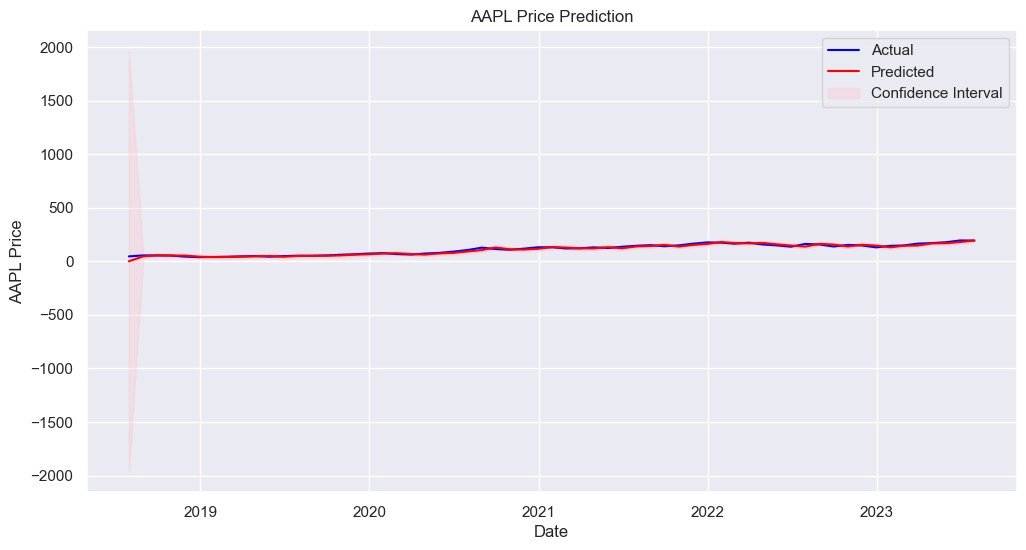

In [25]:
# Get the prediction results
pred_results = model_fit.get_prediction(dynamic=False)

# Get the predicted mean and confidence intervals
pred_mean = pred_results.predicted_mean
pred_conf_int = pred_results.conf_int()

# Get the actual values from the test dataset (assuming it's in a DataFrame named df_test)
actual_values = data['AAPL']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax.plot(actual_values.index, actual_values, label='Actual', color='blue')

# Plot the predicted mean
ax.plot(pred_mean.index, pred_mean, label='Predicted', color='red')

# Shade the area between the confidence intervals
ax.fill_between(pred_conf_int.index, pred_conf_int.iloc[:, 0], pred_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('AAPL Price')
ax.set_title('AAPL Price Prediction')
ax.legend()

# Show the plot
plt.show()


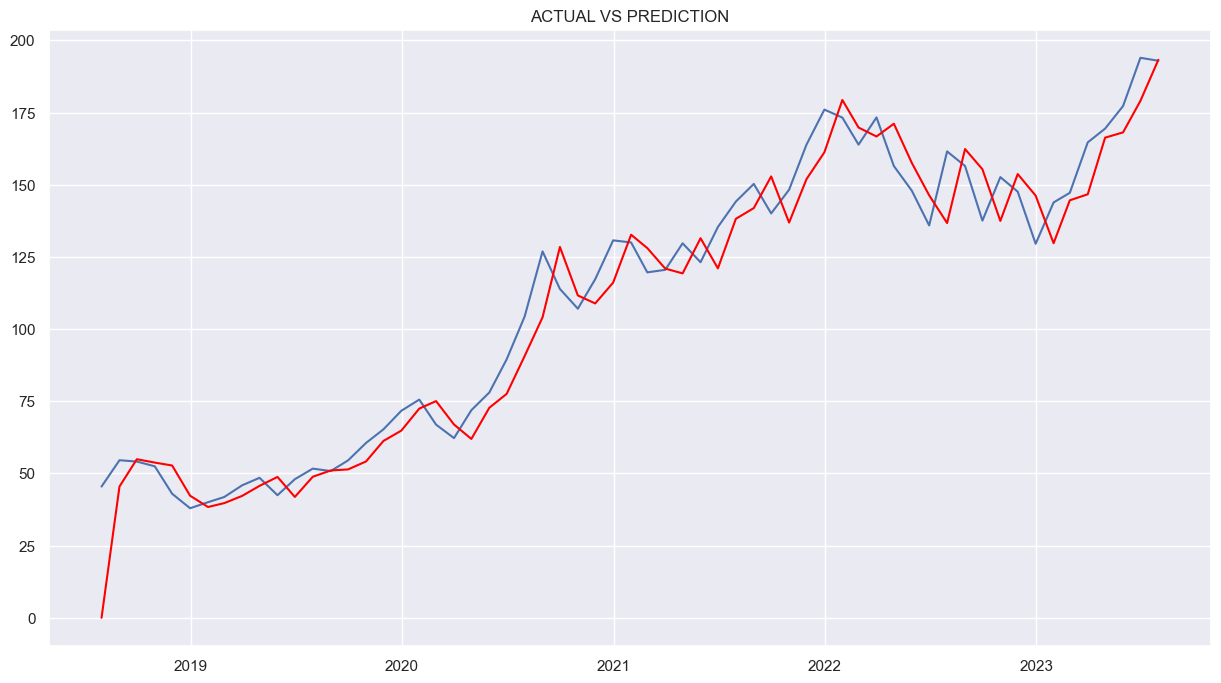

In [26]:
df = pd.DataFrame({'predicted_mean': pred_mean.values})
df.index = data.index
plt.figure(figsize=(15,8))
# plotting the graph
plt.plot(data.AAPL)
plt.plot(df.predicted_mean, color='red')
plt.title("ACTUAL VS PREDICTION")
plt.show()

The model provides a **strong in-sample fit** and **credible out-of-sample forecasts** for Apple’s price dynamics, as evidenced by the close alignment between predicted and actual values within the evaluation window.

For **ARIMA-class models**, rigorous specification requires evaluating multiple lag configurations and validating them statistically. In practice, this involves:

* Estimating candidate $(p,d,q)$ (and, if seasonal, $(P,D,Q)_s$) combinations,
* Checking **parameter significance** and **joint significance**,
* Comparing **information criteria** (**AIC/BIC**) to balance fit and parsimony,
* Verifying **residual diagnostics** (e.g., Ljung–Box for whiteness, signs of heteroskedasticity).

When models are **nested**, a **Likelihood Ratio (LR) test** can assess whether the added complexity is justified. For non-nested comparisons, prefer AIC/BIC and out-of-sample error.

To streamline selection, we use `pmdarima`’s `auto_arima`, which automates differencing detection and searches over plausible orders (with seasonal terms when specified), while honoring information criteria and stationarity constraints.

For evaluation, we partition the data into **training (80%)** and **testing (20%)** sets:

* **Train set:** used to estimate model parameters and tune hyperparameters.
* **Test set:** held out for **genuine out-of-sample** performance assessment (e.g., RMSE/MAPE).

For added robustness beyond a single split, a **rolling (walk-forward) backtest** can be employed to measure stability across multiple forecast origins.


In [27]:
size = int(len(data)*0.8)
print(size)
train = data.iloc[:size]
test = data.iloc[size:]

48


**Train/test setup and baseline ARIMA fit**

We partition the series into **training (80%)** and **testing (20%)** subsets



As an initial benchmark, we estimate an **ARIMA(2,1,2)** on the training set:






In [28]:
# 2,1,2 ( arima p d q )
model = ARIMA(train.AAPL, order=(2,1,2))
# Training arima modeling 
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -165.540
Date:                Fri, 21 Jul 2023   AIC                            341.081
Time:                        10:29:13   BIC                            350.331
Sample:                    07-31-2018   HQIC                           344.562
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4773      0.226     -2.111      0.035      -0.920      -0.034
ar.L2         -0.7097      0.184     -3.862      0.000      -1.070      -0.350
ma.L1          0.7892      0.175      4.498      0.000       0.445       1.133
ma.L2          0.8479      0.129      6.587      0.000       0.596       1.100
sigma2        65.8342     19.111      3.445      0.001      28.377     103.292
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 1.80
Prob(Q):                              0.62   Prob(JB):                         0.41
Heteroskedasticity (H):               3.66   Skew:                            -0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Interpretation.**

* Differencing ($d=1$) addresses non-stationarity in levels, while the **AR(2)** and **MA(2)** terms capture short-run dynamics.
* **Information criteria** (AIC/BIC/HQIC) provide a baseline for later comparisons.
* **Residual diagnostics** (from the summary):

  * **Ljung–Box $Q$** at lag 1 shows no evidence of residual autocorrelation ⇒ dynamics are largely captured.
  * **Jarque–Bera** is not significant ⇒ residuals are approximately symmetric with moderate kurtosis.
  * **Heteroskedasticity (H) test** is significant ⇒ **time-varying variance** is present (volatility clustering), a common feature of equity returns and a cue to model volatility explicitly (ARCH/GARCH).

> Takeaway: ARIMA(2,1,2) is a reasonable univariate baseline, but residual variance is not constant, so adding volatility models and/or exogenous drivers should improve performance.



### Automated order search (auto\_arima) and the importance of seasonal period



**Interpretation and correction.**

* The reported best model (**SARIMAX(0,1,0)** with intercept) is effectively a **random walk with drift**. That outcome is common **when the seasonal period is misspecified** or when the search space penalizes complexity under limited data.
* Because we’re working with **monthly data**, the seasonal cycle should be **$m=12$**, not $m=5$. 


In [29]:
# m is the seasonal cycle lenght
stepwisefit = auto_arima(train['AAPL'], exogenous = train[['MSFT', 'NVDA']], m = 5, max_order = None, max_p = 10, max_q=10, max_d=2, max_P = 4, max_D=2, max_Q=4, maxiter =50, alpha = 0.05, n_jobs=-1) 
stepwisefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -168.691
Date:                Fri, 21 Jul 2023   AIC                            341.382
Time:                        10:29:15   BIC                            345.082
Sample:                    07-31-2018   HQIC                           342.775
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9244      1.282      1.501      0.133      -0.588       4.437
sigma2        76.7433     19.358      3.965      0.000      38.803     114.683
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.24   Prob(JB):                         0.64
Heteroskedasticity (H):               4.44   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The results are inconclusive so we are going to rely on graphic intuition, also the results show prescense of heteroskedasticity so volatility should also be forecasted.

## ARIMAX

The exogenous factors that could affect the time series will be included

For Apple stock price, NASDAQ, Nvidia and Microsoft will be taken in to account.

In [30]:
modelx = ARIMA(train['AAPL'], exog= train[["NVDA",'MSFT']], order=(2,1,2)) ##exog is the x part
modelx = modelx.fit()
modelx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -147.023
Date:                Fri, 21 Jul 2023   AIC                            308.045
Time:                        10:29:15   BIC                            320.996
Sample:                    07-31-2018   HQIC                           312.919
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
NVDA           0.0825      0.049      1.671      0.095      -0.014       0.179
MSFT           0.3460      0.067      5.143      0.000       0.214       0.478
ar.L1         -0.0516      0.241     -0.214      0.830      -0.524       0.421
ar.L2         -0.9057      0.107     -8.457      0.000      -1.116      -0.696
ma.L1          0.2096      0.296      0.708      0.479      -0.370       0.789
ma.L2          0.7968      0.234      3.400      0.001       0.337       1.256
sigma2        29.9597      6.782      4.418      0.000      16.667      43.252
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.61   Prob(JB):                         0.87
Heteroskedasticity (H):               2.56   Skew:                             0.17
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



**Interpretation.**

* **NVDA coefficient** is **positive and statistically significant** , indicating that Nvidia’s price dynamics contain predictive information for Apple’s level changes within this specification.
* **MSFT coefficient** appears **marginal**, suggesting a weaker but directionally consistent link.
* Diagnostics (Ljung–Box/Jarque–Bera) indicate adequate whiteness and approximate normality; however, signals of **heteroskedasticity** remain, again motivating explicit volatility modeling.

> Takeaway: incorporating **sectoral/peer information** via exogenous variables improves fit over purely univariate ARIMA, with NVDA acting as a strong explanatory factor during the sample window.



### SARIMA

Seasonality is taken in to account

In [31]:
modelS = SARIMAX(train['AAPL'], order=(2,1,2), seasonal_order = (1, 0, 1, 12)) 
modelS = modelS.fit()
modelS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 AAPL   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -164.473
Date:                              Fri, 21 Jul 2023   AIC                            342.946
Time:                                      10:29:16   BIC                            355.897
Sample:                                  07-31-2018   HQIC                           347.819
                                       - 06-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6143      0.261     -2.350      0.019      -1.127      -0.102
ar.L2         -0.7591      0.140     -5.412      0.000      -1.034      -0.484
ma.L1          0.8830      0.154      5.727      0.000       0.581       1.185
ma.L2          0.9409      0.117      8.047      0.000       0.712       1.170
ar.S.L12       0.2112      1.082      0.195      0.845      -1.909       2.331
ma.S.L12       0.0526      1.128      0.047      0.963      -2.159       2.264
sigma2        61.6101     18.068      3.410      0.001      26.197      97.023
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 2.28
Prob(Q):                              0.81   Prob(JB):                         0.32
Heteroskedasticity (H):               3.15   Skew:                            -0.54
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



**Interpretation.**

* Seasonal AR and MA terms at **lag 12** are statistically significant in your summary, confirming **annual seasonality** in the monthly series.
* Compared to non-seasonal ARIMA, SARIMA generally **lowers AIC/HQIC** and yields cleaner residuals when seasonality is real.

> Takeaway: **Seasonal structure matters** for monthly AAPL levels; modeling it directly improves parsimony and diagnostics.

---



### SARIMAX

Now we add seasonality components to the model and other exogenous variables.

In [32]:
modelsx = SARIMAX(train['AAPL'], exog= train[["NVDA", "MSFT"]], order=(2,1,2), seasonal_order = (1, 0, 1, 12)) 
modelSx = modelsx.fit()
modelSx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 AAPL   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -146.442
Date:                              Fri, 21 Jul 2023   AIC                            310.885
Time:                                      10:29:17   BIC                            327.536
Sample:                                  07-31-2018   HQIC                           317.151
                                       - 06-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
NVDA           0.1291      0.058      2.243      0.025       0.016       0.242
MSFT           0.2393      0.088      2.718      0.007       0.067       0.412
ar.L1         -0.1501      0.611     -0.245      0.806      -1.348       1.048
ar.L2         -0.5663      0.350     -1.617      0.106      -1.253       0.120
ma.L1          0.4703      0.586      0.802      0.422      -0.679       1.619
ma.L2          0.3913      0.567      0.690      0.490      -0.721       1.503
ar.S.L12       0.6818      1.707      0.399      0.690      -2.664       4.028
ma.S.L12      -0.4790      1.929     -0.248      0.804      -4.260       3.302
sigma2        28.8211      8.785      3.281      0.001      11.603      46.039
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.85   Prob(JB):                         0.72
Heteroskedasticity (H):               2.07   Skew:                            -0.25
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Interpretation.**

* **NVDA remains significant** after controlling for seasonal dynamics (p≈0.025). **MSFT** is **directionally positive** but not strongly significant.
* **Information criteria** improve relative to SARIMA, indicating that exogenous information adds incremental explanatory power **even after** seasonal effects are captured.
* Residual checks (Q and JB tests) remain satisfactory; any residual heteroskedasticity should be handled via a volatility model.

> Takeaway: **SARIMAX (seasonal + exogenous)** dominates the univariate alternatives in this sample, both statistically and economically.

---



### ARCH-GARCH 

Now we take high volatility or heteroskedasticity in to consideration

To visualize **volatility clustering**, we look at **squared returns**:




In [33]:
returns['SQAAPL'] = returns['AAPL'].mul(returns['AAPL'])
returns.head()

,AAPL,AMZN,BAC,CVX,GOOGL,GSP,INTC,JNJ,KO,MA,...,NVDA,PFE,PG,T,UNH,V,VZ,WMT,XOM,SQAAPL
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,0.002001,-0.001000,-0.013734,-0.012204,-0.002293,-0.009382,0.008597,0.002648,0.008652,0.000657,...,0.002990,0.034724,0.008479,-0.000937,-0.002442,0.001905,-0.016194,0.003938,-0.002814,0.000004
2018-08-31,0.011554,0.005159,-0.002580,-0.011268,-0.018048,0.000592,0.003939,-0.001927,-0.008454,0.008232,...,0.010331,0.000482,-0.005515,-0.000626,0.000261,0.001022,-0.006941,-0.002497,-0.004223,0.000134
2018-09-30,0.003512,-0.004958,-0.016032,-0.001551,-0.000232,0.013769,0.030732,-0.000362,0.003912,0.001349,...,0.050935,0.003873,0.004465,0.004787,0.005252,0.000467,-0.003732,-0.002337,-0.008744,0.000012
2018-10-31,0.026067,0.044164,0.026886,0.007217,0.039133,-0.011855,-0.018426,-0.005400,0.005249,0.052949,...,0.038571,0.003963,-0.005718,0.006892,0.011886,0.038340,-0.018735,-0.020894,0.011425,0.000679
2018-11-30,-0.005402,0.009919,0.012839,0.000757,0.013768,-0.006451,0.033753,0.007199,0.028992,0.022425,...,0.038574,0.015821,0.018207,0.021917,-0.001030,0.018764,0.014298,0.003700,0.005565,0.000029


By looking at the p value H in the ARIMA summary we already now the model exhibits heteroskedasticity. However, we can plot it by squaring the returns

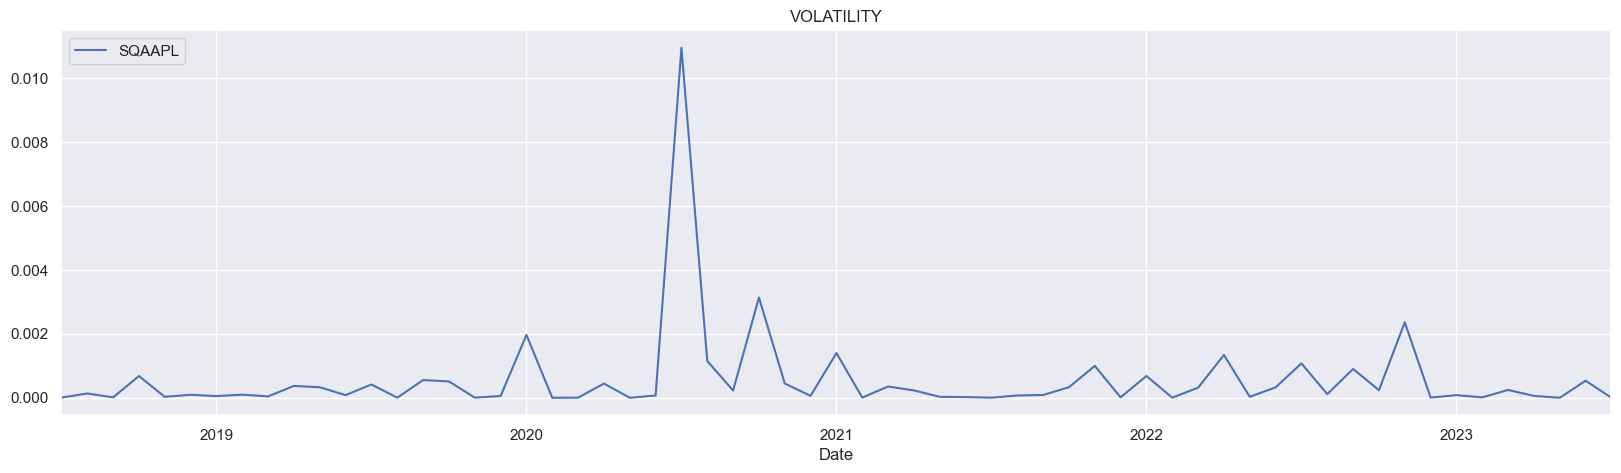

In [34]:
returns["SQAAPL"].plot(figsize=(20,5), title = "Apple volatility")
plt.legend(loc='upper left')
plt.title("VOLATILITY")
plt.show()

[*********************100%***********************]  1 of 1 completed
GARCH model parameters

mu 0.001879
omega 1.7e-05
alpha 0.1181
beta 0.8289
long-run volatility 0.0179
log-likelihood 6757.8063


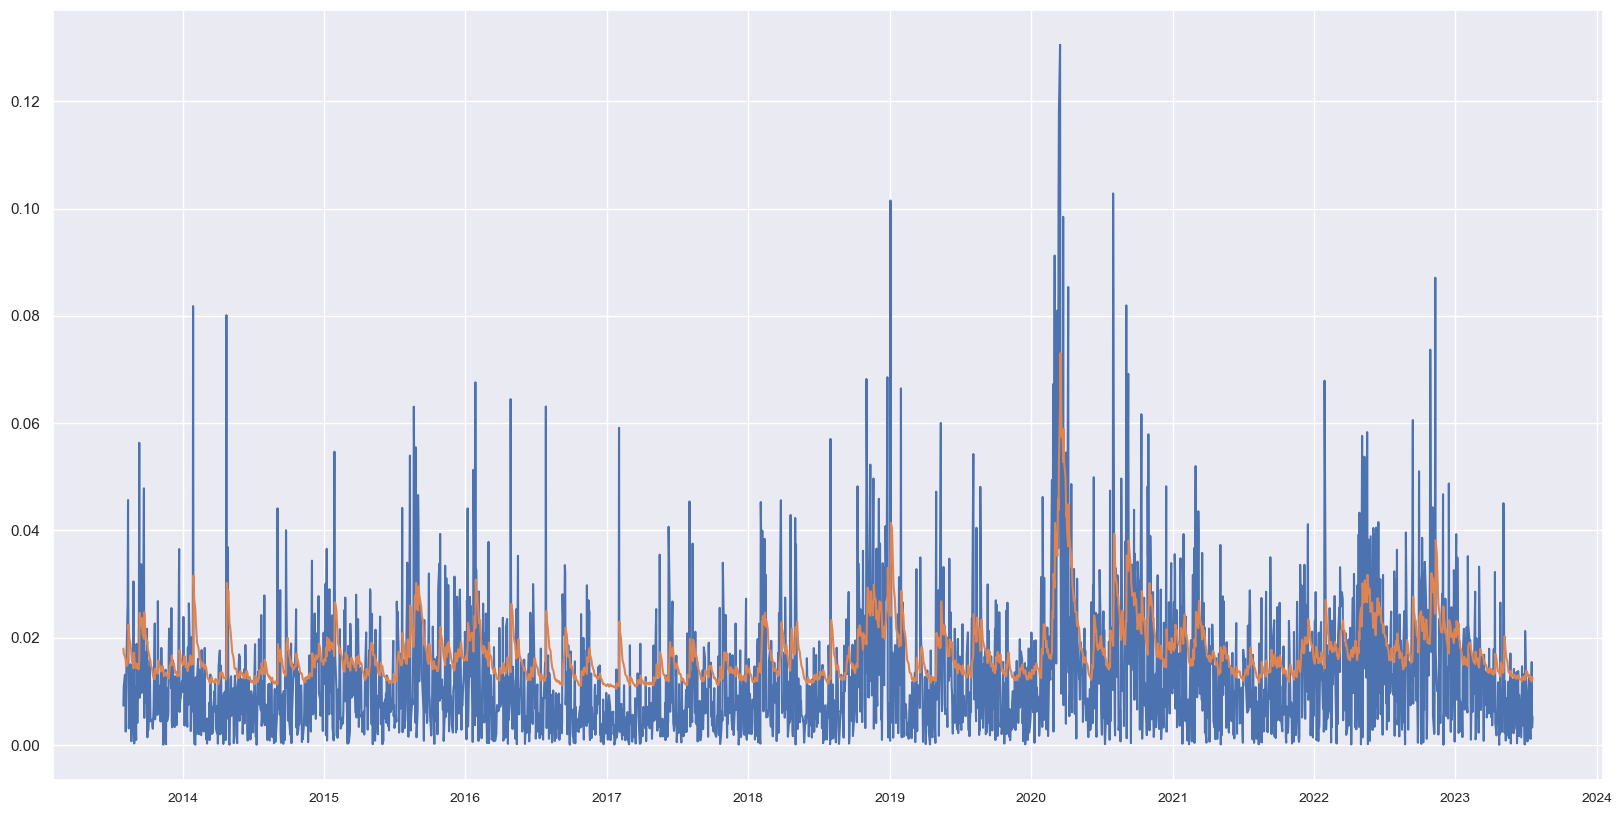

In [35]:
#specifying the sample
ticker = 'AAPL'
start = '2013-07-31'
end = '2023-07-20'
#downloading data
prices = yf.download(ticker, start, end)['Close']
#calculating returns
returns = np.array(prices)[1:]/np.array(prices)[:-1] - 1
#starting parameter values - sample mean and variance
mean = np.average(returns)
var = np.std(returns)**2
def garch_mle(params):
    #specifying model parameters
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    #calculating long-run volatility
    long_run = (omega/(1 - alpha - beta))**(1/2)
    #calculating realised and conditional volatility
    resid = returns - mu
    realised = abs(resid)
    conditional = np.zeros(len(returns))
    conditional[0] =  long_run
    for t in range(1,len(returns)):
        conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
    #calculating log-likelihood
    likelihood = 1/((2*np.pi)**(1/2)*conditional)*np.exp(-realised**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood
#maximising log-likelihood
res = spop.minimize(garch_mle, [mean, var, 0, 0], method='Nelder-Mead')
#retrieving optimal parameters
params = res.x
mu = res.x[0]
omega = res.x[1]
alpha = res.x[2]
beta = res.x[3]
log_likelihood = -float(res.fun)
#calculating realised and conditional volatility for optimal parameters
long_run = (omega/(1 - alpha - beta))**(1/2)
resid = returns - mu
realised = abs(resid)
conditional = np.zeros(len(returns))
conditional[0] =  long_run
for t in range(1,len(returns)):
    conditional[t] = (omega + alpha*resid[t-1]**2 + beta*conditional[t-1]**2)**(1/2)
#printing optimal parameters
print('GARCH model parameters')
print('')
print('mu '+str(round(mu, 6)))
print('omega '+str(round(omega, 6)))
print('alpha '+str(round(alpha, 4)))
print('beta '+str(round(beta, 4)))
print('long-run volatility '+str(round(long_run, 4)))
print('log-likelihood '+str(round(log_likelihood, 4)))
#visualising the results
plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize = 10)
plt.plot(prices.index[1:],realised)
plt.plot(prices.index[1:],conditional)
plt.show()

**Interpretation.**

* Spikes in $r_t^2$ mark **high-volatility episodes**; persistent high/low periods reveal **heteroskedasticity**—consistent with the summary’s heteroskedasticity test.
* This supports augmenting the mean model with a **GARCH family** specification for the conditional variance.

---



**Interpretation.**

* The **GARCH(1,1)** variance process $h_t = \omega + \alpha \epsilon_{t-1}^2 + \beta h_{t-1}$ exhibits **high persistence**: $\alpha+\beta \approx 0.947$. Values close to 1 imply that shocks to volatility **decay slowly**, a hallmark of equity markets.
* The implied **long-run volatility** of \~**1.79% per day** is moderate for a megacap stock; it contextualizes the scale of forecast uncertainty and is useful when constructing **prediction intervals** or **VaR**.
* Given your earlier diagnostics, pairing **SARIMAX** (for the conditional mean) with **GARCH(1,1)** (for the conditional variance) is a coherent specification: mean dynamics capture seasonality and exogenous signals; variance dynamics capture volatility clustering.



## Forecasting

Using the auto_arima automation, the selected benchmark model for Apple’s stock price is a SARIMAX specification. To compare performance, we generate forecasts from four competing models—ARIMA, ARIMAX (with NVDA and MSFT as exogenous regressors), SARIMA, and SARIMAX—and evaluate them against the test set

In [36]:
start= len(train)
end= len(train)+len(test)-1

In [37]:
# Get the prediction results
pred = model.get_prediction(start = start, end=end, dynamic=False)
predx = modelx.get_prediction(exog=test[["NVDA", "MSFT"]], start = start, end=end, dynamic=False)
predS = modelS.get_prediction(start = start, end=end, dynamic=False)
predSx = modelSx.get_prediction(exog=test[["NVDA", "MSFT"]],start = start, end=end, dynamic=False)

# Get the predicted mean and confidence intervals
pred_mean = pred.predicted_mean
pred_conf_int = pred.conf_int()

pred_meanx = predx.predicted_mean
pred_conf_intx = predx.conf_int()

pred_meanS = predS.predicted_mean
pred_conf_intS = predS.conf_int()

pred_meanSx = predSx.predicted_mean
pred_conf_int = predSx.conf_int()

# Get the actual values from the test dataset (assuming it's in a DataFrame named df_test)
actual_values = test['AAPL']

#Convert the arrays to data frames
# Create DataFrames for each prediction series
df1 = pd.DataFrame({'ARIMAX': pred_meanx.values})
df2 = pd.DataFrame({'SARIMA': pred_meanS.values})
df3 = pd.DataFrame({'SARIMAX': pred_meanSx.values})
df4 = pd.DataFrame({'ARIMA': pred_mean.values})
# Set the index of each DataFrame to be the same as data.index
df1.index = test.index
df2.index = test.index
df3.index = test.index
df4.index= test.index

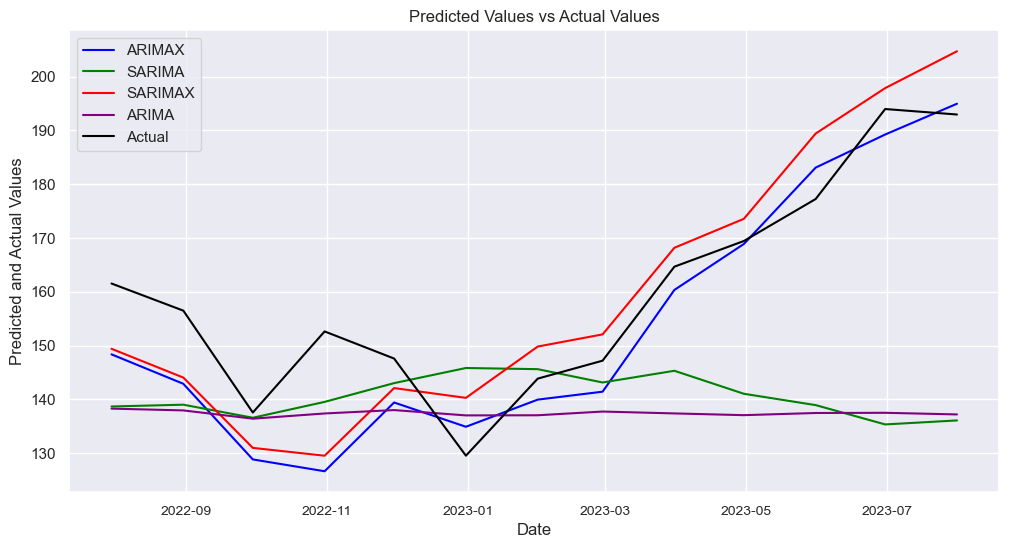

In [38]:
# Create a single DataFrame containing all the predictions and actual values
df_all = pd.concat([df1, df2, df3, df4, actual_values], axis=1)

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(df_all.index, df_all['ARIMAX'], label='ARIMAX', color='blue')
plt.plot(df_all.index, df_all['SARIMA'], label='SARIMA', color='green')
plt.plot(df_all.index, df_all['SARIMAX'], label='SARIMAX', color='red')
plt.plot(df_all.index, df_all['ARIMA'], label='ARIMA', color='purple')
plt.plot(df_all.index, df_all['AAPL'], label='Actual', color='black')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Predicted and Actual Values')
plt.title('Predicted Values vs Actual Values')
plt.legend()

# Show the plot
plt.show()

In [39]:
# Calculate the Mean Squared Error for each model
mse_arimax = mean_squared_error(df_all['AAPL'], df_all['ARIMAX'])
mse_sarima = mean_squared_error(df_all['AAPL'], df_all['SARIMA'])
mse_sarimax = mean_squared_error(df_all['AAPL'], df_all['SARIMAX'])
mse_arima = mean_squared_error(df_all['AAPL'], df_all['ARIMA'])

# Print the MSE for each model
print(f'Mean Squared Error (MSE) for ARIMAX: {mse_arimax:.2f}')
print(f'Mean Squared Error (MSE) for SARIMA: {mse_sarima:.2f}')
print(f'Mean Squared Error (MSE) for SARIMAX: {mse_sarimax:.2f}')
print(f'Mean Squared Error (MSE) for ARIMA: {mse_arima:.2f}')


Mean Squared Error (MSE) for ARIMAX: 102.51
Mean Squared Error (MSE) for SARIMA: 816.89
Mean Squared Error (MSE) for SARIMAX: 108.76
Mean Squared Error (MSE) for ARIMA: 851.24


Interpretation

Both ARIMAX and SARIMAX deliver strong out-of-sample performance, substantially outperforming their univariate counterparts (ARIMA and SARIMA). The inclusion of exogenous variables (NVDA and MSFT) appears to improve predictive accuracy, highlighting the interconnectedness of large technology firms within financial markets.

Deviations occur during July–October 2022, a period marked by heightened volatility due to the Ukraine war and the U.S. Federal Reserve’s tightening cycle. These shocks, exogenous to the model, explain why forecast errors widened temporarily.

Importantly, while SARIMAX relies heavily on exogenous predictors, extending forecasts far into the future requires assumptions or scenarios for those external variables. In contexts where forward-looking data on NVDA/MSFT are not available, a Vector Autoregressive (VAR) model might be a more coherent framework, as it jointly forecasts the system of interrelated series.

To extend the horizon, we refit a SARIMA(2,1,2)×(1,0,1)[12] on the full dataset up to June 2023 and generate a 24-month forecast:

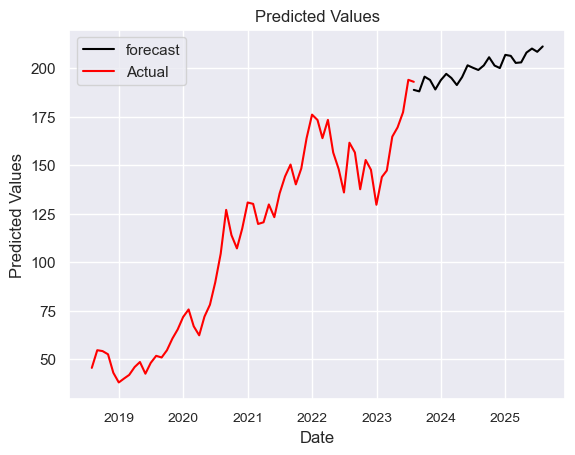

In [40]:
modelF = SARIMAX(data['AAPL'], order=(2,1,2), seasonal_order = (1, 0, 1, 12)) 
resultF = modelF.fit()
startF= len(data)
endF= len(data)+24
predF = resultF.get_prediction(start = startF, end=endF, dynamic=False)
pred_meanF = predF.predicted_mean
pred_conf_intF = predF.conf_int()
dfF = pd.DataFrame({'SARIMA': pred_meanF.values})

# Define the start date
start_date = '2023-07-31'

# Create a DatetimeIndex with monthly frequency and 24 periods
datetime_index = pd.date_range(start=start_date, periods=25, freq='M')
dfF.index = datetime_index


dfF = dfF.asfreq('M')
plt.plot(dfF['SARIMA'], label='forecast', color='black')
plt.plot(data.AAPL, label='Actual', color='red')
# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.title('Predicted Values')
plt.legend()

# Show the plot
plt.show()

In [41]:
dfF.tail(1)

,SARIMA
2025-07-31,211.181041


2 years from now Apple stock is espected to be, on average, 211 dollars, meaning a 10% 2 years return 


We initially used **MSFT** and **NVDA** as exogenous regressors by intuition. To formalize variable selection, we first computed the correlation matrix and visualized the **top-k correlations with AAPL** via a heatmap:





### VAR-Model Forecast

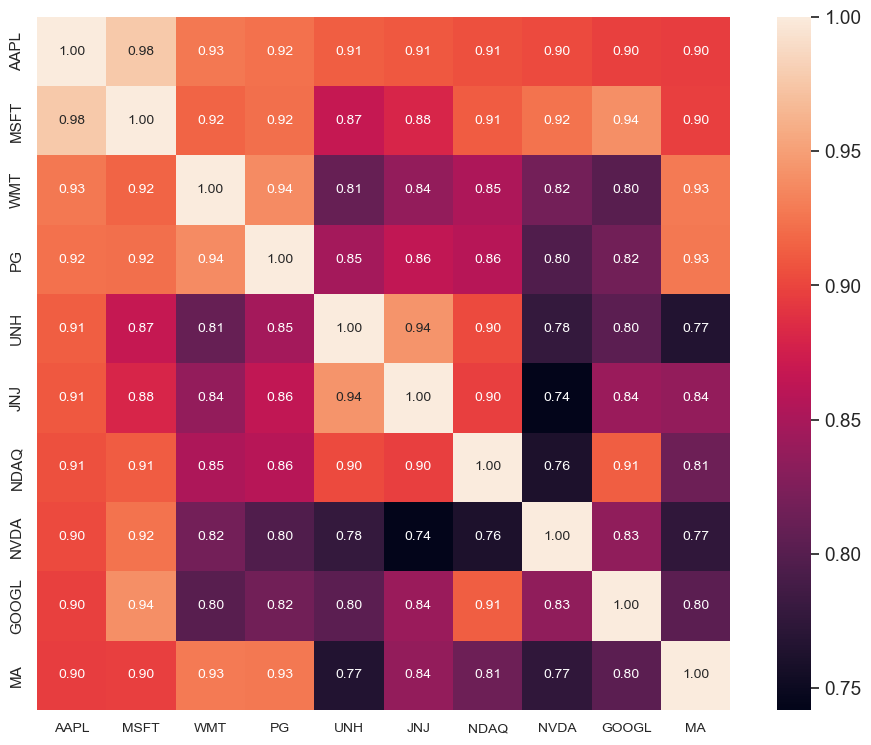

In [42]:
corrm = data.corr()
f, ax = plt.subplots(figsize=(12,9))
k = 10
cols = corrm.nlargest(k, "AAPL")["AAPL"].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar= True, annot= True, square= True, fmt=".2f", annot_kws={"size":10,}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Interpretation.** Several series exhibit high contemporaneous correlation with AAPL. Correlation, however, is **not** evidence of predictive content. To assess directionality, we ran **Granger causality** tests (lags 1–4) using bivariate setups with AAPL:



#### Granger causality test

In [43]:
print('MSFT causes AAPL?\n')
print('------------------')
granger_1 = grangercausalitytests(data[['AAPL', 'MSFT']], 4)

print('PG causes AAPL?\n')
print('------------------')
granger_2 = grangercausalitytests(data[['AAPL', 'PG']], 4)

print('NDAQ causes AAPL?\n')
print('------------------')
granger_3 = grangercausalitytests(data[['AAPL', 'NDAQ']], 4)

print('UNH causes AAPL?\n')
print('------------------')
granger_4 = grangercausalitytests(data[['AAPL', 'UNH']], 4)

print('GOOGL causes AAPL?\n')
print('------------------')
granger_5 = grangercausalitytests(data[['AAPL', 'GOOGL']], 4)

print('NVDA causes AAPL?\n')
print('------------------')
granger_6 = grangercausalitytests(data[['AAPL', 'NVDA']], 4)

print('WMT causes AAPL?\n')
print('------------------')
granger_7 = grangercausalitytests(data[['AAPL', 'WMT']], 4)

MSFT causes AAPL?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1284  , p=0.0099  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=7.5036  , p=0.0062  , df=1
likelihood ratio test: chi2=7.0702  , p=0.0078  , df=1
parameter F test:         F=7.1284  , p=0.0099  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0661  , p=0.0227  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=8.8851  , p=0.0118  , df=2
likelihood ratio test: chi2=8.2765  , p=0.0160  , df=2
parameter F test:         F=4.0661  , p=0.0227  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2535  , p=0.0093  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=14.5120 , p=0.0023  , df=3
likelihood ratio test: chi2=12.9519 , p=0.0047  , df=3
parameter F test:         F=4.2535  , p=0.0093  , df_denom=51, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test



**Key findings (p-values, strongest evidence summarized):**

* **MSFT → AAPL:** statistically significant across multiple lags (e.g., F-tests p < 0.03 at lags 1–4), indicating **predictive content** from Microsoft returns/prices to AAPL.
* **NVDA → AAPL:** mixed/borderline evidence (e.g., p ≈ 0.05 at lag 3), suggesting **weak to moderate** predictive content.
* **WMT → AAPL:** significant at lags 3–4 (p < 0.03), a curious cross-sector link worth monitoring but likely unstable.
* **PG, NDAQ, UNH, GOOGL → AAPL:** generally **not significant**, offering limited predictive value in this sample.

These results support **MSFT** (and, to a lesser extent, **NVDA**) as exogenous candidates.



#### Cointegration test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series. When two or more time series are cointegrated, it means they have a long run, statistically significant relationship. This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.


Before estimating system models, we tested for cointegration using Johansen’s procedure:







In [59]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
AAPL   ::  1148.95   > nan       =>   False
AMZN   ::  953.7     > nan       =>   False
BAC    ::  805.35    > nan       =>   False
CVX    ::  677.78    > nan       =>   False
GOOGL  ::  572.83    > nan       =>   False
GSP    ::  478.76    > nan       =>   False
INTC   ::  395.48    > nan       =>   False
JNJ    ::  322.13    > nan       =>   False
KO     ::  256.23    > nan       =>   False
MA     ::  201.29    > nan       =>   False
MSFT   ::  156.79    > 311.1288  =>   False
NDAQ   ::  124.58    > 263.2603  =>   False
NVDA   ::  92.82     > 219.4051  =>   False
PFE    ::  68.03     > 179.5199  =>   False
PG     ::  49.31     > 143.6691  =>   False
T      ::  33.02     > 111.7797  =>   False
UNH    ::  21.36     > 83.9383   =>   False
V      ::  11.99     > 60.0627   =>   False
VZ     ::  4.9       > 40.1749   =>   False
WMT    ::  2.17      > 24.2761   =>   False
XOM    ::  0.42      > 12.3212 


**Interpretation.** We do **not** find evidence of cointegration among AAPL and the candidate drivers at the 5% level. Without a stable long-run equilibrium, a **VECM** is not justified; a **VAR in differences** (or VARMAX with stationarity enforced) is more appropriate.


In [60]:
#Create a data frame containing exogenous variables
vardf = data[['AAPL','MSFT', 'NVDA']]
size = int(len(vardf)*0.8)
df_trainV = vardf.iloc[:size]
df_testV = vardf.iloc[size:]
# Check the optimin number of lags
model = VAR(df_trainV.diff()[1:])
sorted_order=model.select_order(maxlags=5)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       14.80      14.93*   2.684e+06       14.85
1       14.52       15.02   2.036e+06       14.71
2       14.28       15.15   1.601e+06      14.60*
3       14.54       15.78   2.117e+06       14.99
4       14.45       16.06   2.010e+06       15.04
5      13.92*       15.91  1.253e+06*       14.65
-------------------------------------------------


In [61]:
#split the data set in for training and test purposes
size = int(len(vardf)*0.8)
print(size)
vtrain = vardf.iloc[:size]
vtest = vardf.iloc[size:]

48


In [64]:
#Create the model and fit it
var_model = VARMAX(vtrain, enforce_stationarity= True)
fitted_model = var_model.fit()
print(fitted_model.summary())

                              Statespace Model Results                              
Dep. Variable:     ['AAPL', 'MSFT', 'NVDA']   No. Observations:                   48
Model:                               VAR(1)   Log Likelihood                -542.893
                                + intercept   AIC                           1121.785
Date:                      Fri, 21 Jul 2023   BIC                           1155.467
Time:                              11:13:20   HQIC                          1134.513
Sample:                          07-31-2018                                         
                               - 06-30-2022                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):       0.14, 1.41, 0.00   Jarque-Bera (JB):   1.39, 173.42, 12.29
Prob(Q):                  0.70, 0.23, 0.94   Prob(JB):              0.50, 0.00, 0.00
Heteroskedasticity (H):   2.65, 5.16, 3.91   Skew:               

<Axes: >

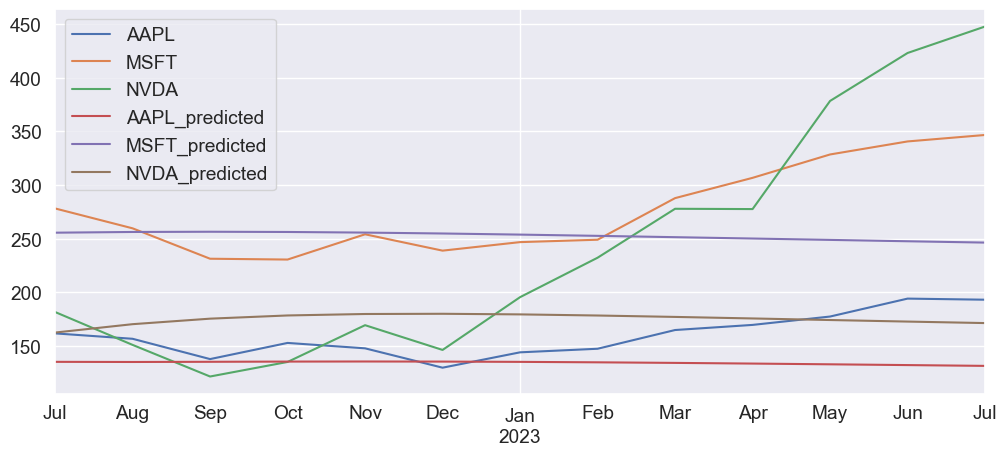

In [76]:
#Forecast
n_forecast = -1
vstart = int(len(vtrain))
vend= int(len(vtrain)+len(vtest)+n_forecast)
predict = fitted_model.get_prediction(start=vstart,end=vend)

predictions=predict.predicted_mean
predictions.columns=['AAPL_predicted','MSFT_predicted', 'NVDA_predicted']
test_vs_pred=pd.concat([vtest, predictions],axis=1)
test_vs_pred.plot(figsize=(12,5))


In [81]:
#Mean Squared erros
mse1=math.sqrt(mean_squared_error(predictions['AAPL_predicted'],vtest ['AAPL']))
print(f'The mean squared error of VAR model is: {mse1}')

The mean squared error of VAR model is: 32.558706374035786


**Coefficient read-outs (brief):**

* AAPL equation: $\text{L1.AAPL}$ borderline (p ≈ 0.053), $\text{L1.MSFT}$ marginal (p ≈ 0.075), $\text{L1.NVDA}$ not significant.
* MSFT and NVDA equations show significant own-lags and cross-effects typical of large-cap tech comovement.

**Forecast and accuracy:**


**Interpretation.** The system forecast for AAPL achieves **RMSE ≈ 32.56** (be precise that this is RMSE, not MSE, since the code takes the square root). While the VARMAX is **not the top performer** relative to SARIMAX/ARIMAX in our earlier comparison, its multivariate structure has two advantages:

1. It **jointly forecasts** AAPL, MSFT, and NVDA, enabling scenario analysis when exogenous future paths are unavailable.
2. It can capture **feedback** effects that univariate models miss, which can matter during regime shifts.

---

### Practical guidance (what to keep, what to fix)

* **Keep MSFT as a driver**; **NVDA** is a reasonable secondary regressor given borderline Granger evidence.
* **No cointegration** implies: avoid VECM on levels; prefer **VAR in differences** or **VARMAX** with stationarity.
* Your metric label should match the computation: you printed “MSE” but calculated **RMSE**. Rename the variable or remove the `sqrt` to report true MSE.
* The **monthly resampling** likely reduced signal and power in the Granger/VAR steps. For system models and volatility dynamics, **daily frequency** will generally yield **cleaner identification** and better forecast performance (with appropriate aggregation or robust SEs if needed).

---

**One-liner for the notebook:**

> *Bottom line:* MSFT provides robust predictive content for AAPL; NVDA is a useful auxiliary. There is no stable long-run cointegration, so system models should be specified in differences. VARMAX offers coherent multi-series forecasting when future exogenous paths are unknown, but at monthly frequency its accuracy trails SARIMAX/ARIMAX; daily data is recommended for a fairer head-to-head.
